In [1]:
from forced_convection_dft.forward_models import ForwardModelDft, ForwardModelThermocouple
from forced_convection_dft.find_incident_heat_flux import HeatFluxFinder
from dft_inverse_code import dft_models, heat_transfer_coefficients
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 4

# Simulation info

In [2]:
dt = .5
constant = 273.15
time_vector = np.arange(0, 11 * 60 + dt, dt)


# Properties

In [3]:
diameter_tc = 1.4e-3
density_tc = 8665
heat_capacity_tc = 485.6 
emissivity_tc = 0.8
alpha_tc = 0.8
dft_thickness =  0.0016
insulation_thickness = .019
plate_side_length = .0762

In [12]:
velocities = np.linspace(0.1, 15, 10)
fluxes = np.linspace(5, 150, 10)
temperatures_inf = np.linspace(21, 1000, 10)
velocities_grid, fluxes_grid, temperatures_grid = np.meshgrid(velocities, fluxes, temperatures_inf)
temperatures_grid = temperatures_grid.flatten()
velocities_grid = velocities_grid.flatten()
fluxes_grid = fluxes_grid.flatten()
errors_framework = []
errors_nat_conv = []
q_inc_true = np.zeros((len(velocities_grid), len(time_vector)))
q_inc_recovered_framework = np.zeros((len(velocities_grid), len(time_vector)))
q_inc_recovered_nat_conv = np.zeros((len(velocities_grid), len(time_vector)))

heat_transfer_coefs = np.zeros((len(velocities_grid), len(time_vector)))
temperatures_front_plate = np.zeros((len(velocities_grid), len(time_vector)))

In [13]:
for i, (temp, vel, flux) in enumerate(zip(temperatures_grid, velocities_grid, fluxes_grid)):
    velocity = np.ones(len(time_vector)) * vel
    q_inc = np.ones_like(time_vector) * flux * 1e3
    q_inc[time_vector < 3 * 60] = 0
    q_inc[time_vector > 8 * 60] = 0
    forward_dft = ForwardModelDft(n_nodes=10, time=time_vector, insul_thickness=insulation_thickness, plate_thickness=dft_thickness, q_inc=q_inc,
                 characteristic_velocity=velocity, temp_init=21 + constant, temp_amb=temp + constant, temp_surr=21 + constant, dft_plate_length=plate_side_length)
    temp_f, temp_b, temp_ins, h_f, h_b = forward_dft.run()
    forward_tc = ForwardModelThermocouple(time_vector, q_inc, velocity, 21 + constant,
                     temp + constant, 21 + constant, emissivity_tc, alpha_tc, diameter_tc, heat_capacity_tc,
                     density_tc)
    temp_tc = forward_tc.run()
    hf_finder = HeatFluxFinder(temp_f, temp_b, temp_tc, temp + constant,
                   21 + constant, 21 + constant, time_vector, diameter_tc,
                   alpha_tc, alpha_tc, heat_capacity_tc, density_tc, 
                           constant_velocity=True,  
                           plate_side_length=plate_side_length)
    q_inc_plate_recovered = hf_finder.find_q_inc()
    error = np.abs((q_inc_plate_recovered - q_inc / 1e3) / (q_inc / 1e3))
    errors_framework.append(error[np.isfinite(error)].mean() * 100)
    q_inc_true[i] = q_inc
    q_inc_recovered_framework[i] = q_inc_plate_recovered
    heat_transfer_coefs[i] = h_f
    temperatures_front_plate[i] = temp_f
    
    h_f_nat = heat_transfer_coefficients.natural_convection(
            (temp_f + 21 + constant).reshape(-1, 1) / 2, Kelvin=True,
           T_infty=temp + constant).custom(0.65, 0.25).flatten()
    q_inc_plate_recovered = dft_models.one_dim_conduction(T_f=temp_f, T_b=temp_b, time=time_vector, h_f=h_f_nat, h_b=h_b, model='one_d_conduction', Kelvin=True, T_inf=temp + constant, T_sur=21 + constant).q_inc

    error = np.abs((q_inc_plate_recovered - q_inc / 1e3) / (q_inc / 1e3))
    errors_nat_conv.append(error[np.isfinite(error)].mean() * 100)
    

100%|██████████| 1320/1320 [00:00<00:00, 15230.70it/s]


In [14]:
conv_fluxes = (heat_transfer_coefs * (temperatures_front_plate - constant - temperatures_grid[:, np.newaxis])).mean(axis=-1) / 1e3

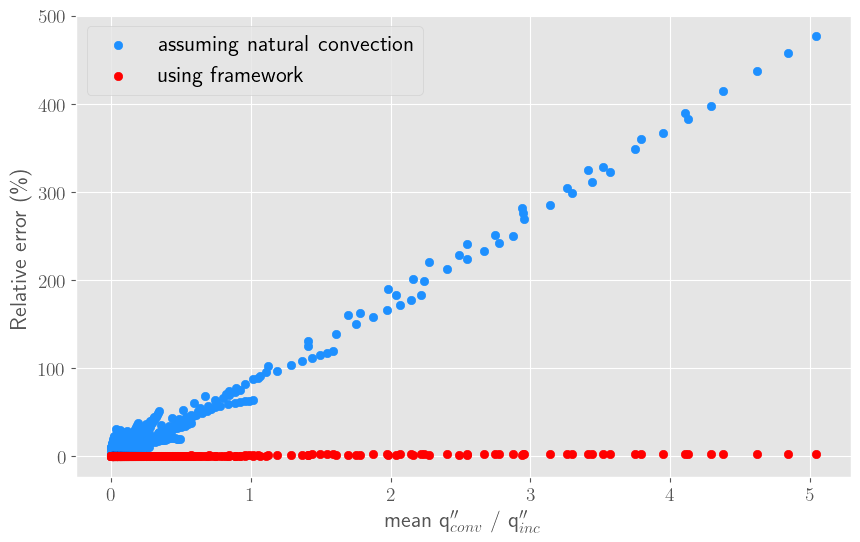

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(np.abs(conv_fluxes) / fluxes_grid, errors_nat_conv, color='dodgerblue', label='assuming natural convection')
plt.scatter(np.abs(conv_fluxes) / fluxes_grid, errors_framework, color='red', label='using framework')
plt.xlabel("mean q$''_{conv}$ / q$''_{inc}$")
plt.ylabel('Relative error (\%)')
plt.legend();

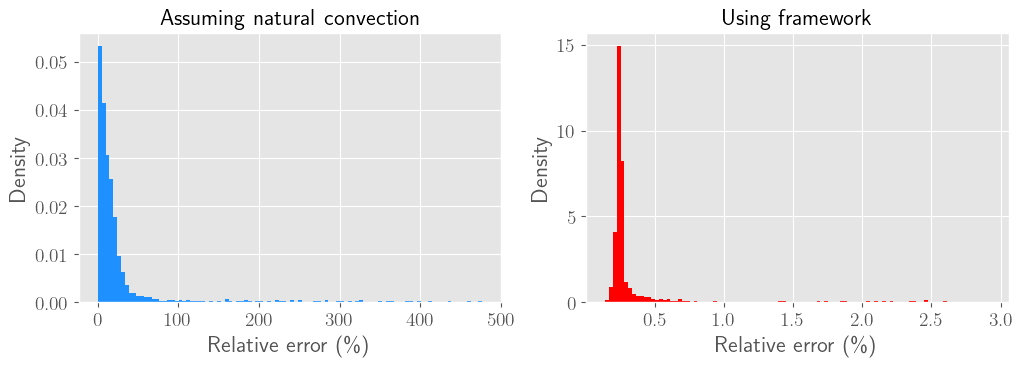

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(12, 3.5))
axes[0].hist(errors_nat_conv, bins=100, density=True, color='dodgerblue')
axes[0].set_title('Assuming natural convection')
axes[1].hist(errors_framework, bins=100, density=True, color='red');
axes[1].set_title('Using framework')
[ax.set(xlabel='Relative error (\%)', ylabel='Density') for ax in axes];

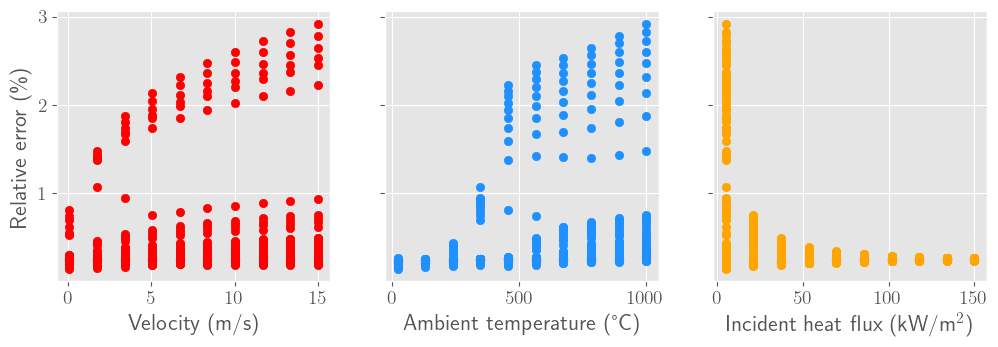

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(12, 3.5))
axes[0].scatter(velocities_grid, errors_framework, color='red')
axes[0].set_xlabel('Velocity (m/s)')
axes[1].scatter(temperatures_grid, errors_framework, color='dodgerblue')
axes[1].set_xlabel('Ambient temperature (°C)')
axes[2].scatter(fluxes_grid, errors_framework, color='orange')
axes[2].set_xlabel('Incident heat flux (kW/m$^2$)');
axes[0].set_ylabel('Relative error (\%)');